In [2]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 1000  # Adjust as per your data
tot_iter = 10000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt[:, i, :], dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {total_loss}')

# Optional: Additional code for visualization or further processing goes here

start


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [3]:
Yt.shape


torch.Size([3, 10000, 1000])

In [4]:
i

0

In [5]:
Yt[:,0,:]

tensor([[-1.4301, -0.6277, -3.2913,  ...,  2.0854,  3.8733,  2.9577],
        [-0.0426, -0.6747, -0.5345,  ..., -0.3076,  0.4455, -0.1984],
        [-1.0570,  0.7554, -3.8997,  ...,  3.6111,  4.4903,  4.0063]],
       grad_fn=<SliceBackward0>)

In [6]:
Yt[:, i, :].shape

torch.Size([3, 1000])

In [7]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 1000  # Adjust as per your data
tot_iter = 10000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {total_loss}')

# Optional: Additional code for visualization or further processing goes here

start


NameError: name 'C_target' is not defined

In [8]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 1000  # Adjust as per your data
tot_iter = 10000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {total_loss}')

# Optional: Additional code for visualization or further processing goes here

start
Iteration 0, Loss: 1.4203155040740967


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

Restarted Houman_Py (Python 3.9.17)

In [1]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 1000  # Adjust as per your data
tot_iter = 10000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    if i % 100 == 0:
        print(f'Iteration {i}, Loss: {total_loss}')

start
Iteration 0, Loss: 0.9370811581611633


Restarted Houman_Py (Python 3.9.17)

In [1]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 1000  # Adjust as per your data
tot_iter = 10000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')

start
Iteration 0, Loss: 1.195847988128662
Iteration 1, Loss: 0.840173065662384
Iteration 2, Loss: 0.7175410389900208
Iteration 3, Loss: 0.9458709359169006
Iteration 4, Loss: 1.0565283298492432
Iteration 5, Loss: 0.7785887122154236
Iteration 6, Loss: 0.7090440392494202
Iteration 7, Loss: 0.7374861240386963
Iteration 8, Loss: 0.5163698792457581
Iteration 9, Loss: 0.6454210877418518
Iteration 10, Loss: 0.3250505328178406
Iteration 11, Loss: 0.6698693633079529


Restarted Houman_Py (Python 3.9.17)

In [1]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 100  # Adjust as per your data
tot_iter = 100
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')

start
Iteration 0, Loss: 1.422364592552185
Iteration 1, Loss: 1.3866969347000122
Iteration 2, Loss: 1.307042121887207
Iteration 3, Loss: 1.2084041833877563
Iteration 4, Loss: 1.0227411985397339
Iteration 5, Loss: 0.6415987014770508
Iteration 6, Loss: 0.5435536503791809
Iteration 7, Loss: 0.9836350083351135
Iteration 8, Loss: 0.5904320478439331
Iteration 9, Loss: 0.3174554407596588
Iteration 10, Loss: 0.9495173692703247
Iteration 11, Loss: 0.514625608921051
Iteration 12, Loss: 0.37049874663352966
Iteration 13, Loss: 0.8121256828308105
Iteration 14, Loss: 0.29923921823501587
Iteration 15, Loss: 0.6445876955986023
Iteration 16, Loss: 0.6012969613075256
Iteration 17, Loss: 0.18533799052238464
Iteration 18, Loss: 0.6155229806900024
Iteration 19, Loss: 0.16488398611545563
Iteration 20, Loss: 0.6709362268447876
Iteration 21, Loss: 0.16998516023159027
Iteration 22, Loss: 0.44379812479019165
Iteration 23, Loss: 0.5396862626075745
Iteration 24, Loss: 0.1544998586177826
Iteration 25, Loss: 0.6483

start
Iteration 0, Loss: 1.541942834854126


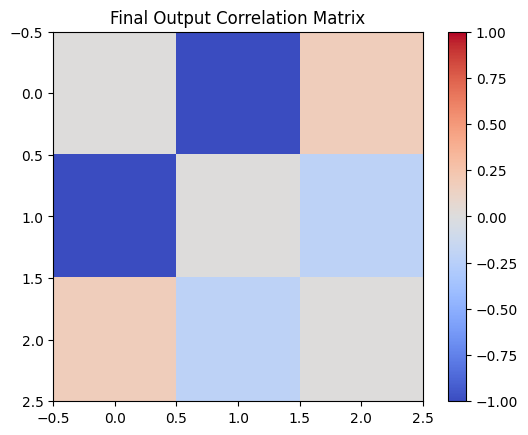

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

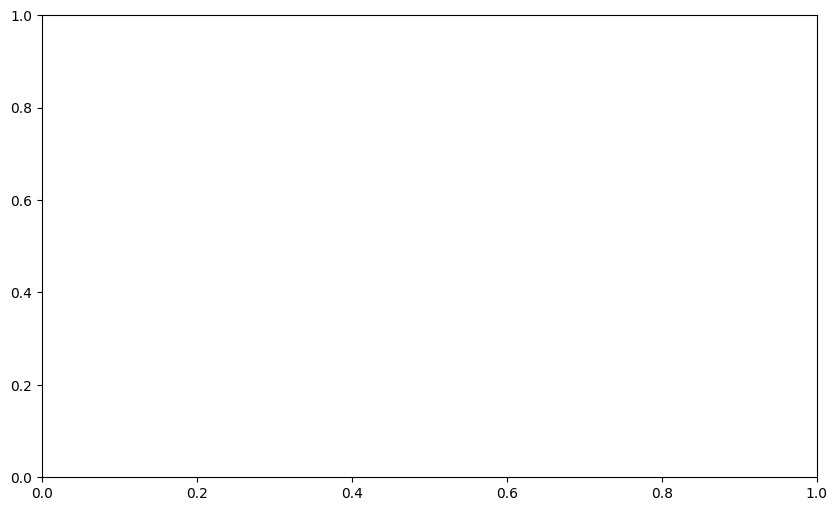

In [2]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 100  # Adjust as per your data
tot_iter = 1000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')

    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()



    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()

start
Iteration 0, Loss: 1.0218263864517212


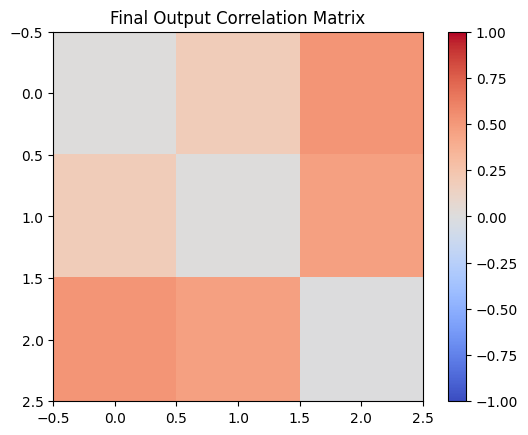

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

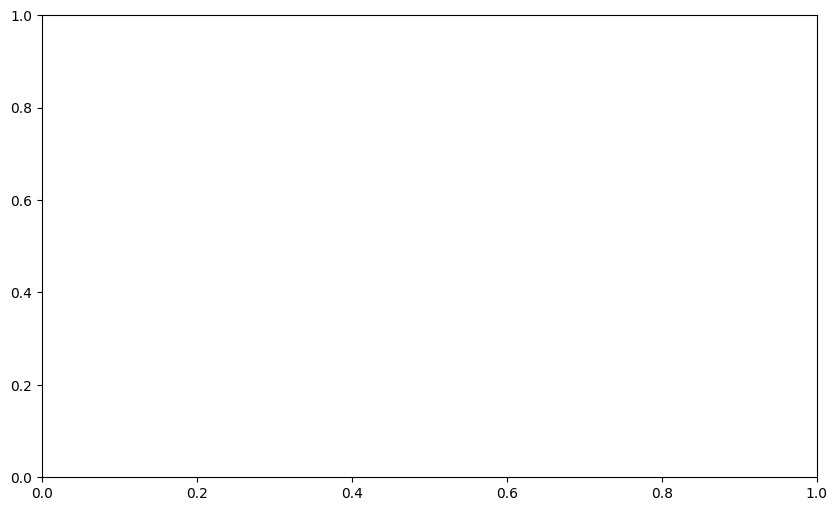

In [3]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 100  # Adjust as per your data
tot_iter = 1000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')

    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()



    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()

In [4]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 100  # Adjust as per your data
tot_iter = 1000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')


# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()



# Select a single input representation to plot
selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

# Plot all components of Yt over time for the selected input on the same subplot
plt.figure(figsize=(10, 6))
for i in range(Yt.shape[0]):  # Loop over the output dimensions
    plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
plt.xlabel('Time (in 1000s of iterations)')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

start
Iteration 0, Loss: 1.6631251573562622
Iteration 1, Loss: 1.4784588813781738
Iteration 2, Loss: 1.4421541690826416
Iteration 3, Loss: 1.4117507934570312
Iteration 4, Loss: 1.3708467483520508
Iteration 5, Loss: 1.3088735342025757
Iteration 6, Loss: 1.1971876621246338
Iteration 7, Loss: 0.9790663719177246
Iteration 8, Loss: 0.45662549138069153
Iteration 9, Loss: 1.033554196357727
Iteration 10, Loss: 0.8980432152748108
Iteration 11, Loss: 0.3399263918399811
Iteration 12, Loss: 0.8116617798805237
Iteration 13, Loss: 0.7252139449119568
Iteration 14, Loss: 0.1166476309299469
Iteration 15, Loss: 0.2924720048904419
Iteration 16, Loss: 0.3379049599170685
Iteration 17, Loss: 0.7618274688720703
Iteration 18, Loss: 0.47088393568992615
Iteration 19, Loss: 0.32852253317832947
Iteration 20, Loss: 0.6617692112922668
Iteration 21, Loss: 0.09636852890253067
Iteration 22, Loss: 0.407937616109848
Iteration 23, Loss: 0.5814809799194336
Iteration 24, Loss: 0.1645074337720871
Iteration 25, Loss: 0.66220

KeyboardInterrupt: 

Restarted Houman_Py (Python 3.9.17)

In [1]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 500  # Adjust as per your data
tot_iter = 1000
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')


# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()



# Select a single input representation to plot
selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

# Plot all components of Yt over time for the selected input on the same subplot
plt.figure(figsize=(10, 6))
for i in range(Yt.shape[0]):  # Loop over the output dimensions
    plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
plt.xlabel('Time (in 1000s of iterations)')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

start
Iteration 0, Loss: 1.3795928955078125
Iteration 1, Loss: 1.2904165983200073
Iteration 2, Loss: 1.117995262145996
Iteration 3, Loss: 0.7559679746627808
Iteration 4, Loss: 0.5063979029655457
Iteration 5, Loss: 0.8836849331855774
Iteration 6, Loss: 0.3118346631526947
Iteration 7, Loss: 0.3606835603713989
Iteration 8, Loss: 0.9138161540031433
Iteration 9, Loss: 0.36752164363861084
Iteration 10, Loss: 0.6393651366233826
Iteration 11, Loss: 0.5277608036994934
Iteration 12, Loss: 0.35619544982910156
Iteration 13, Loss: 0.6211020350456238
Iteration 14, Loss: 0.12984348833560944
Iteration 15, Loss: 0.7238131761550903
Iteration 16, Loss: 0.09387973695993423
Iteration 17, Loss: 0.7084853053092957
Iteration 18, Loss: 0.22555404901504517
Iteration 19, Loss: 0.3754996359348297
Iteration 20, Loss: 0.48248082399368286
Iteration 21, Loss: 0.18198594450950623
Iteration 22, Loss: 0.5674115419387817
Iteration 23, Loss: 0.052880626171827316
Iteration 24, Loss: 0.5586774349212646
Iteration 25, Loss: 0

KeyboardInterrupt: 

Restarted Houman_Py (Python 3.9.17)

start
Iteration 0, Loss: 0.943709135055542
Iteration 1, Loss: 0.34660303592681885
Iteration 2, Loss: 0.0686023086309433
Iteration 3, Loss: 0.6938493847846985
Iteration 4, Loss: 0.3999193608760834
Iteration 5, Loss: 0.3639119267463684
Iteration 6, Loss: 0.5345987677574158
Iteration 7, Loss: 0.23009051382541656
Iteration 8, Loss: 0.598250687122345
Iteration 9, Loss: 0.10683781653642654
Iteration 10, Loss: 0.3747761845588684
Iteration 11, Loss: 0.22422072291374207
Iteration 12, Loss: 0.46925920248031616
Iteration 13, Loss: 0.1609632968902588
Iteration 14, Loss: 0.5107545852661133
Iteration 15, Loss: 0.08321843296289444
Iteration 16, Loss: 0.5215767025947571
Iteration 17, Loss: 0.09646834433078766
Iteration 18, Loss: 0.3158055245876312
Iteration 19, Loss: 0.17275334894657135
Iteration 20, Loss: 0.42324012517929077
Iteration 21, Loss: 0.21888461709022522
Iteration 22, Loss: 0.369147926568985
Iteration 23, Loss: 0.28859996795654297
Iteration 24, Loss: 0.2825595736503601
Iteration 25, Loss: 0

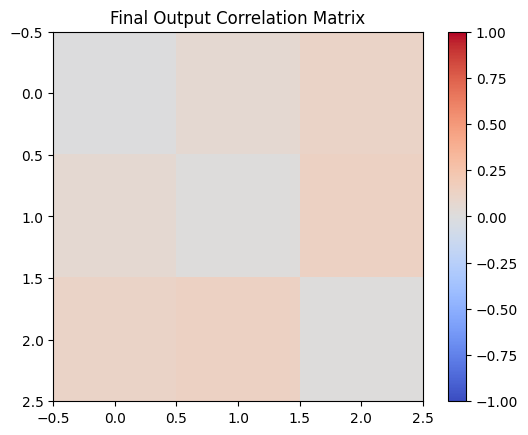

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

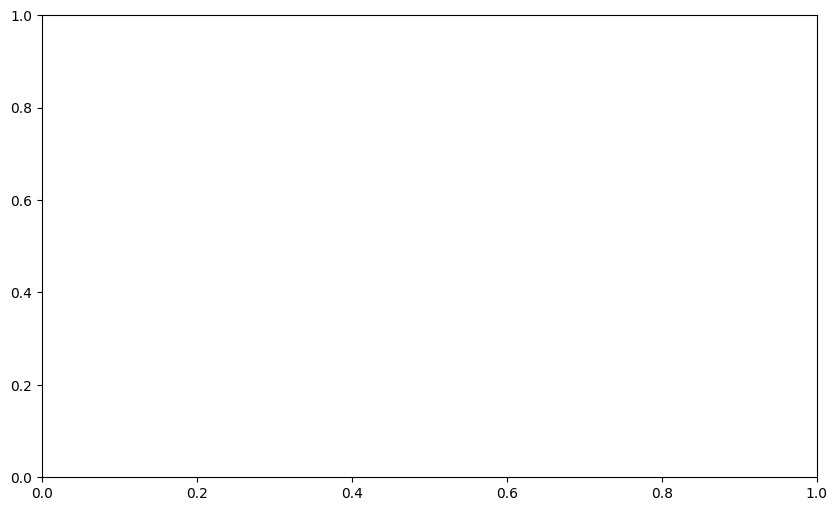

In [1]:
if 1==2:
    import numpy as np
    from numpy.linalg import inv, norm, eigh
    from scipy.stats import multivariate_normal
    import matplotlib.pyplot as plt

    def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
        V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
        C = V @ np.diag(input_cov_eigens) @ V.T
        X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample).T
        num_test = 100
        Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test).T
        return X, Xtest, V

    # Parameters from MATLAB code
    input_dim = 10
    output_dim = 3
    num_sample = 1000
    tot_iter = 10000
    syn_noise_std = 1e-2
    learnRate = 1e-1
    #input_cov_eigens = [4.5, 3.5, 1] + [0.01] * 7
    input_cov_eigens = [1, 1, 1] + [0.01] * 7
    num_sel = 200  # Number of randomly selected samples for detailed tracking
    step_for_record = 10  # Interval of iterations to record the representations
    num_samples_to_track = 200  # Number of samples you want to track

    # Generate input data
    X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)
    _, S, _ = np.linalg.svd(X @ X.T / num_sample)
    Vnorm = norm(S[:output_dim])


    # Initialize weights
    W = np.random.randn(output_dim, input_dim)
    M = np.eye(output_dim)

    # Initialize tracking variables
    pspErr = []
    featureMapErr = []
    SMerror = []
    Yt = np.zeros((output_dim, tot_iter // step_for_record, num_samples_to_track))

    Yt = np.zeros((output_dim, tot_iter, num_sample))

    # Simulation with noisy synaptic updates
    for i in range(tot_iter):
        for idx in range(num_sample):  # Compute Y for each input at each iteration
            x_curr = X[:, idx]
            noise_W = np.random.normal(0, syn_noise_std, W.shape)
            noise_M = np.random.normal(0, syn_noise_std, M.shape)

            Y = inv(M) @ W @ x_curr.reshape(-1, 1)  # Neural representation for current input
            W = (1 - learnRate) * W + learnRate * Y @ x_curr.reshape(1, -1) + noise_W
            M = (1 - learnRate) * M + learnRate * (Y @ Y.T) + noise_M

            Yt[:, i, idx] = Y.squeeze()  # Store the neural representation
        
        if i % 100 == 0:  # Calculate errors every 1000 iterations for performance
            F = inv(M) @ W
            psp_error = norm(F.T @ F - V[:, :output_dim] @ V[:, :output_dim].T, 'fro') / Vnorm
            pspErr.append(psp_error)
            feature_map_error = norm(F @ F.T - np.eye(output_dim), 'fro')
            featureMapErr.append(feature_map_error)
            Ysel = F @ X[:, :200]  # Select 200 samples for similarity matrix calculation
            SM0 = Ysel.T @ Ysel
            sm_error = norm(SM0 - SM0, 'fro') / (norm(SM0, 'fro') + 1e-10)
            SMerror.append(sm_error)
                    # Randomly select num_sel inputs to track (for demonstration, replace with your selection logic)
            sel_idx = np.random.choice(range(X.shape[1]), num_sel, replace=False)
            for j, idx in enumerate(sel_idx):
                x_sel = X[:, idx]
                Y_sel = inv(M) @ W @ x_sel.reshape(-1, 1)

    # Plotting PSP error over time
    plt.figure(figsize=(10, 4))
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Error')
    plt.title('PSP Error over Time')
    plt.legend()
    plt.show()


    # Assuming pspErr contains the PSP error over time
    # And Yt contains neural representations over selected time points for a subset of inputs

    # Plot PSP Error over time
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(pspErr, label='PSP Error')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('PSP Error')
    plt.title('PSP Error over Iterations')
    plt.legend()

    # Plot a sample of neural representations
    # For simplicity, let's plot the first dimension of neural representations of a selected input over time
    selected_input = 0  # Change as needed
    plt.subplot(1, 2, 2)
    plt.plot(Yt[0, :, selected_input], label=f'Neural Representation of Input {selected_input}')
    plt.xlabel('Iterations (x1000)')
    plt.ylabel('Output Value')
    plt.title(f'Neural Representation of Selected Input Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()


    # Select a single input representation to plot
    selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

    # Plot all components of Yt over time for the selected input on the same subplot
    plt.figure(figsize=(10, 6))
    for i in range(Yt.shape[0]):  # Loop over the output dimensions
        plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
    plt.xlabel('Time (in 1000s of iterations)')
    plt.ylabel('Activation')
    plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
    plt.legend()
    plt.show()










    import torch
    import numpy as np

    # Generate synthetic data
    input_dim = 10
    num_samples = 10000
    X = torch.randn(num_samples, input_dim)

    # Define network parameters
    output_dim = 3
    weights = torch.randn(input_dim, output_dim, requires_grad=True)
    learning_rate = 1e-3

    # Define the target correlation matrix
    C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

    # Training loop
    num_epochs = 10000
    for epoch in range(num_epochs):
        # Forward pass: Compute predicted output
        Y_pred = X @ weights
        
        # Compute the correlation matrix of the outputs
        Y_mean = torch.mean(Y_pred, dim=0, keepdim=True)
        Y_centered = Y_pred - Y_mean
        covariance = Y_centered.T @ Y_centered / (num_samples - 1)
        variance = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
        C_pred = covariance / (variance @ variance.T)
        
        # Compute loss as the difference between the predicted and target correlation matrices
        loss = torch.norm(C_pred - C_target, p='fro')
        
        # Zero gradients, perform a backward pass, and update the weights.
        if weights.grad is not None:
            weights.grad.zero_()
        loss.backward()
        
        with torch.no_grad():
            weights -= learning_rate * weights.grad

        # Print loss every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    # Check the final correlation matrix
    print("Final predicted correlation matrix:")
    print(C_pred.detach().numpy())


    # Plot the final correlation matrix
    plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Final Output Correlation Matrix")
    plt.show()

############################################################
############################################################
############################################################
############################################################
############################################################

print('start')
import torch
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

def generate_PSP_input(input_cov_eigens, input_dim, num_sample):
    V = np.linalg.qr(np.random.randn(input_dim, input_dim))[0]
    C = V @ np.diag(input_cov_eigens) @ V.T
    X = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_sample)
    num_test = 100
    Xtest = multivariate_normal.rvs(mean=np.zeros(input_dim), cov=C, size=num_test)
    return torch.tensor(X, dtype=torch.float32).T, torch.tensor(Xtest, dtype=torch.float32).T, V

# Parameters
input_dim = 10
output_dim = 3
num_sample = 200  # Adjust as per your data
tot_iter = 200
syn_noise_std = 1e-2
learnRate = 1e-1
input_cov_eigens = [1, 1, 1] + [0.01] * 7

C_target = torch.tensor([[1.0, 0.5, 0.0],
                            [0.5, 1.0, 0.0],
                            [0.0, 0.0, 1.0]])

# Generate input data
X, Xtest, V = generate_PSP_input(input_cov_eigens, input_dim, num_sample)

# PyTorch setup
W = torch.randn(output_dim, input_dim, requires_grad=True)
M = torch.eye(output_dim, requires_grad=True)
optimizer = torch.optim.SGD([W, M], lr=learnRate)

# Placeholder for neural representations
Yt = torch.zeros((output_dim, tot_iter, num_sample), requires_grad=False)

for i in range(tot_iter):
    total_loss = 0  # Reset total loss for each iteration
    for idx in range(num_sample):
        
        x_curr = X[:, idx].unsqueeze(1)  # Ensure x_curr is [input_dim, 1]

        # Generate noise matching the dimensions of W and M
        noise_W = torch.randn_like(W) * syn_noise_std
        noise_M = torch.randn_like(M) * syn_noise_std

        # Perturb W and M with noise for the current computation
        W_perturbed = W + noise_W
        M_perturbed = M + noise_M

        # Compute the neural representation Y using perturbed weights
        # Note: We're using torch.inverse(M_perturbed) to simulate M^-1 in the equation Y = M^-1 * W * x
        # It's more numerically stable to solve the system of linear equations than to explicitly calculate the inverse.
        Y = torch.linalg.solve(M_perturbed, torch.mm(W_perturbed, x_curr))

        Yt[:, i, idx] = Y.squeeze()  # Store the neural representation

    # Calculate correlation cost
    Y_mean = torch.mean(Yt, dim=2, keepdim=True)
    Y_centered = Yt[:, i, :] - Y_mean[:, i, :]
    covariance = torch.mm(Y_centered, Y_centered.T) / (num_sample - 1)
    std_devs = torch.sqrt(torch.diag(covariance)).reshape(-1, 1)
    C_pred = covariance / (std_devs @ std_devs.T)

    # Loss calculation
    loss = torch.norm(C_pred - C_target, p='fro')
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward(retain_graph=True)  # Add retain_graph=True here
    optimizer.step()

    print(f'Iteration {i}, Loss: {total_loss}')


# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()



# Select a single input representation to plot
selected_input = np.random.randint(0, Yt.shape[2])  # For example, random selection

# Plot all components of Yt over time for the selected input on the same subplot
plt.figure(figsize=(10, 6))
for i in range(Yt.shape[0]):  # Loop over the output dimensions
    plt.plot(Yt[i, :, selected_input], label=f'Component {i+1}')
plt.xlabel('Time (in 1000s of iterations)')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

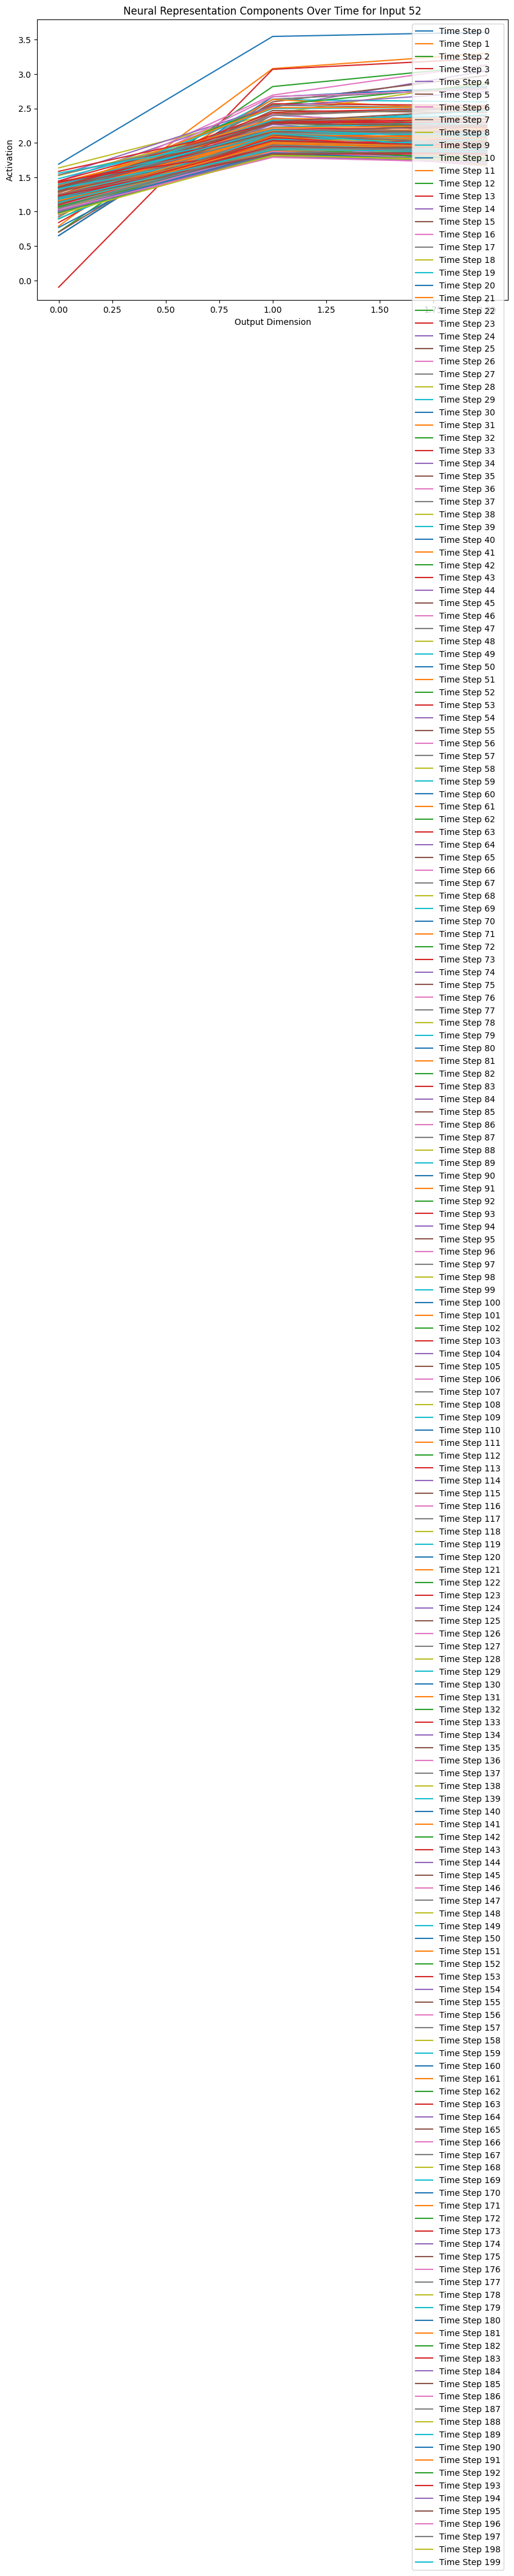

In [2]:
# Plot all components of Yt over time for the selected input on the same subplot
selected_input = np.random.randint(0, num_sample)  # Randomly select an input
plt.figure(figsize=(10, 6))
for i in range(tot_iter):  # Loop over time steps
    plt.plot(Yt[:, i, selected_input].detach().numpy(), label=f'Time Step {i}')
plt.xlabel('Output Dimension')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

In [3]:

# Plot all components of Yt over time for the selected input on the same subplot
selected_input = np.random.randint(0, num_sample)  # Randomly select an input
plt.figure(figsize=(10, 6))
for i inrange(Yt.shape[0]):  # Loop over the output dimensions
    plt.plot(Yt[i, :, selected_input].detach().numpy(), label=f'Time Step {i}')
plt.xlabel('Output Dimension')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-3-b569cf173212>, line 4)

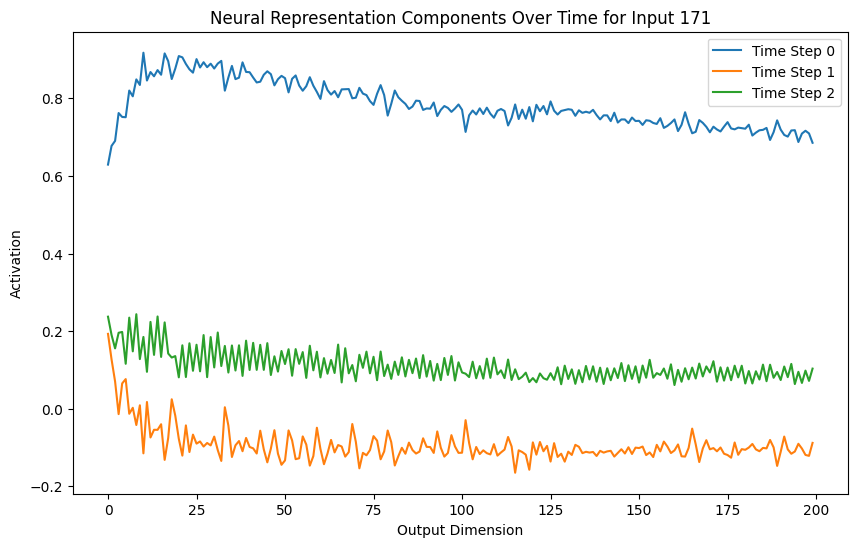

In [4]:

# Plot all components of Yt over time for the selected input on the same subplot
selected_input = np.random.randint(0, num_sample)  # Randomly select an input
plt.figure(figsize=(10, 6))
for i in range(Yt.shape[0]):  # Loop over the output dimensions
    plt.plot(Yt[i, :, selected_input].detach().numpy(), label=f'Time Step {i}')
plt.xlabel('Output Dimension')
plt.ylabel('Activation')
plt.title(f'Neural Representation Components Over Time for Input {selected_input}')
plt.legend()
plt.show()

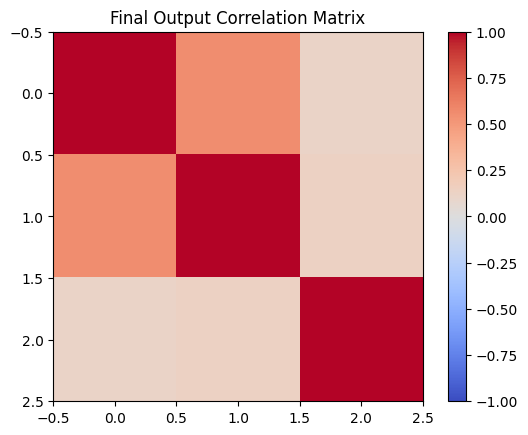

In [5]:

# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()


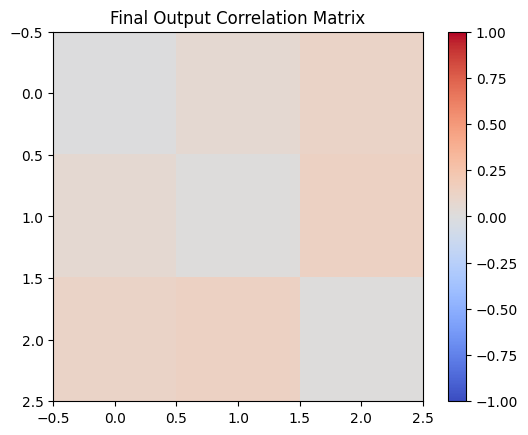

In [6]:

# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

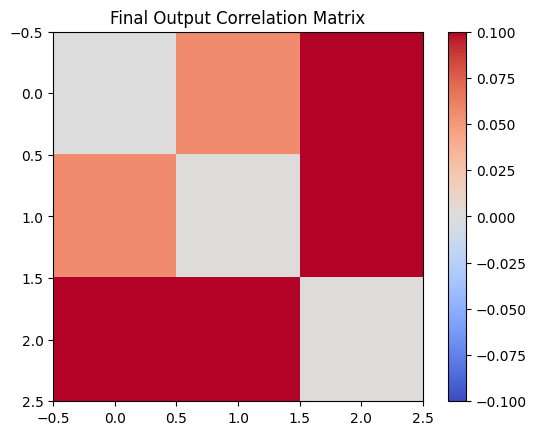

In [7]:

# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='coolwarm', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()


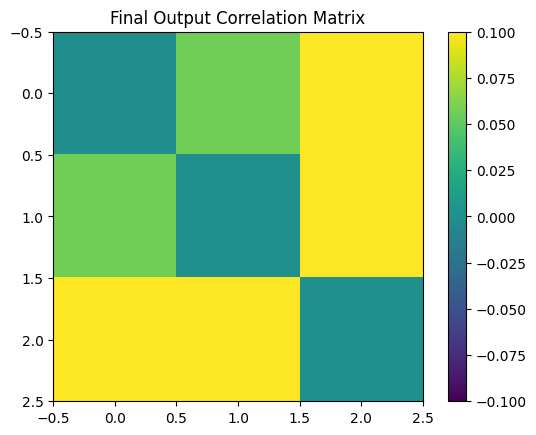

In [8]:

# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='viridis', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

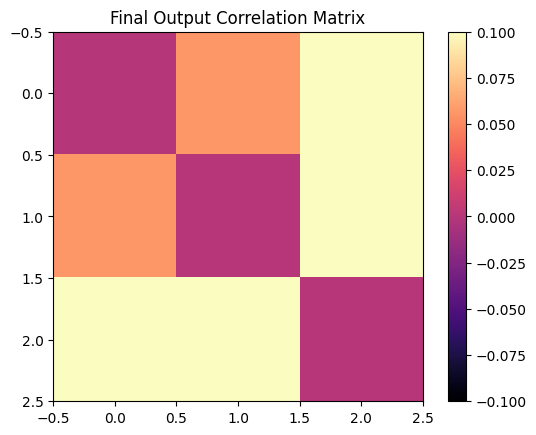

In [9]:

# Plot the final correlation matrix
plt.imshow(C_pred.detach().numpy()-C_target.detach().numpy(), cmap='magma', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

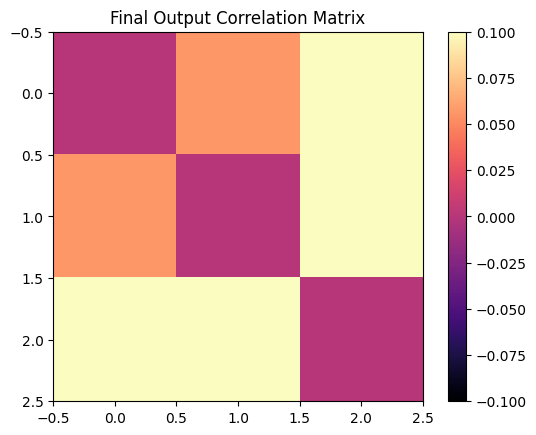

In [10]:
# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='magma', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()


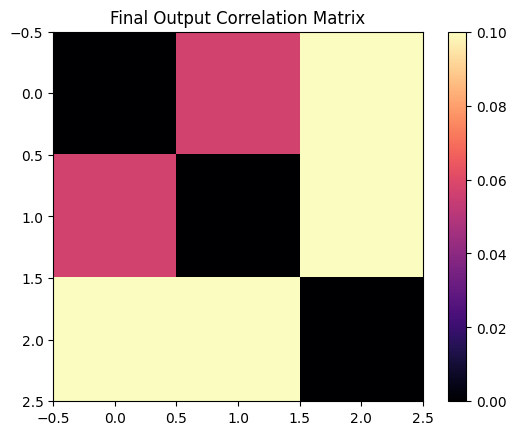

In [11]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='magma', vmin=0, vmax=0.1)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()


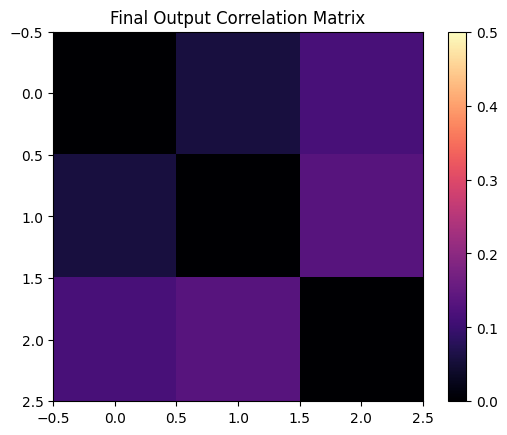

In [12]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='magma', vmin=0, vmax=0.5)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()



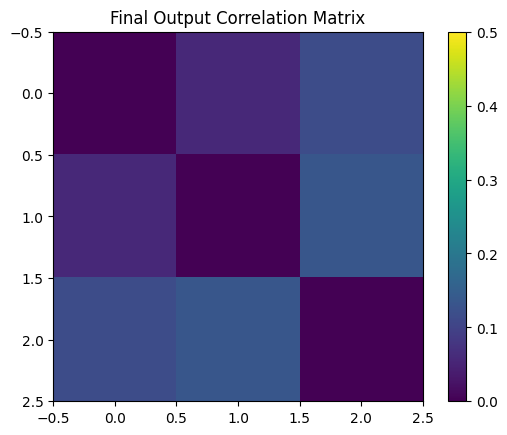

In [13]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='viridis', vmin=0, vmax=0.5)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

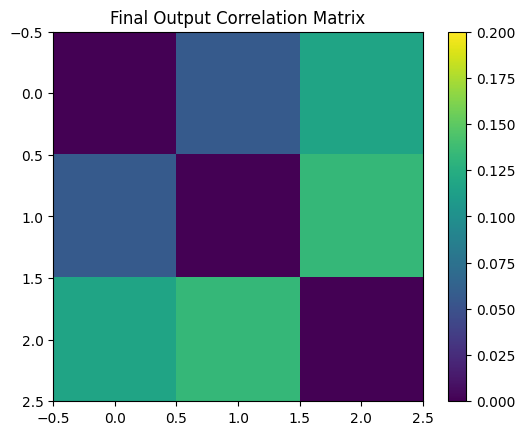

In [14]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='viridis', vmin=0, vmax=0.2)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

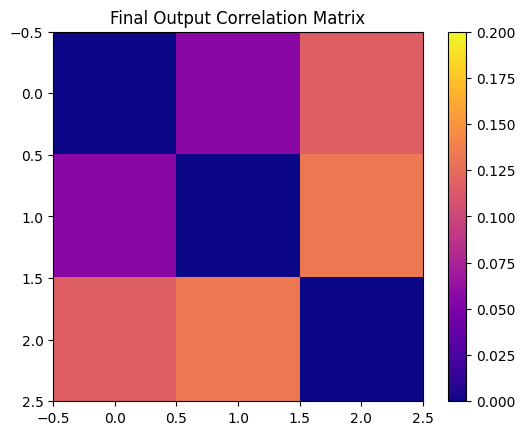

In [15]:


# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='plasma', vmin=0, vmax=0.2)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()


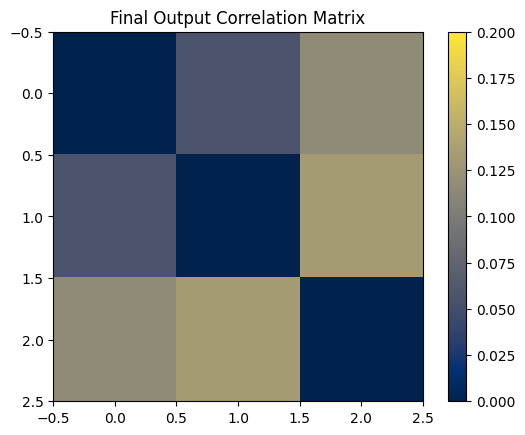

In [16]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='cividis', vmin=0, vmax=0.2)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()

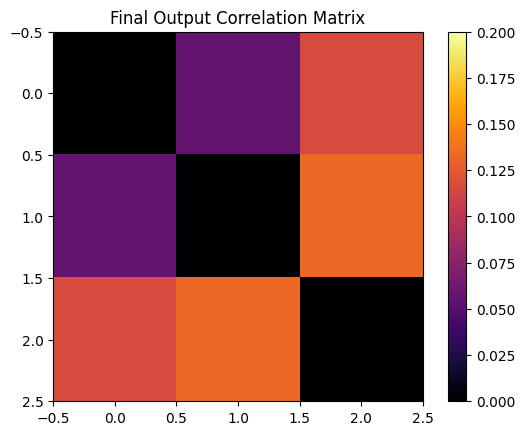

In [17]:

# Plot the final correlation matrix
plt.imshow(np.abs(C_pred.detach().numpy()-C_target.detach().numpy()), cmap='inferno', vmin=0, vmax=0.2)
plt.colorbar()
plt.title("Final Output Correlation Matrix")
plt.show()
